In [2]:

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from dataclasses import dataclass
import numpy as np
import plotly.graph_objects as go

import rf_network as rn
import notebook_tools as nt

from tqdm import tqdm
import cv2
import os
from network_simulator import NetworkSimulator

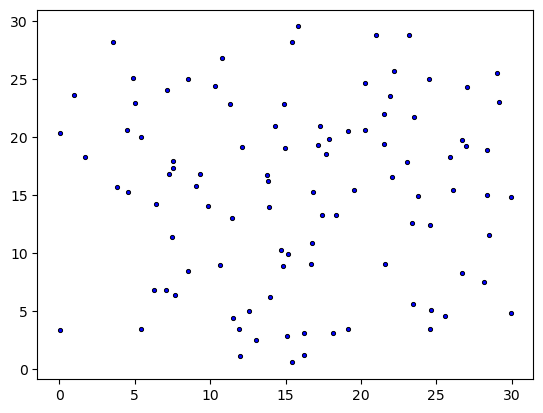

In [16]:
nodes = rn.create_nodes_samples(rn.NodesDistributionParams())
fig=plt.figure()
plt.subplot(111)
#nt.figure_visualize_nodes(nodes)
nt.visualize_nodes(nodes,fig,"blue",is_plotly=False)





In [6]:
nodes = rn.create_nodes_samples(rn.NodesDistributionParams())

is_plotly = True
fig=nt.figure_visualize_nodes(nodes,is_plotly=is_plotly)
rn.update_nodes_location(nodes,60)
fig=nt.figure_visualize_nodes(nodes,fig,nodes_color='red',edges_color='red',is_plotly=is_plotly)
rn.update_nodes_location(nodes,60)
fig=nt.figure_visualize_nodes(nodes,fig,nodes_color='green',edges_color='green',is_plotly=is_plotly)
fig.show()



In [4]:
# import plotly.io as pio
# # pio.kaleido.scope.mathjax=None
# img_bytes=pio.to_image(fig,format='png',width= 1920,height = 1080)


# img_np = np.array(Image.open(io.BytesIO(img_bytes)))

In [8]:

np.random.seed(1)
sim = NetworkSimulator(simulation_rate=10)
sim.step()
sim.step()
sim.step()
sim.step()
sim.step()


fig = go.Figure()

nt.visualize_nodes(sim.nodes,fig,'blue')
nt.visualize_cmatrix(sim.nodes,sim.current_connectivity,fig,reported_cmatrix=sim.reported_connectivity)
    # Update the layout
fig.update_layout(
    title='Nodes',
    xaxis_title='km',
    yaxis_title='km',
    width=1000,
    height=1000
    )
   
    

Processing: 100%|██████████| 120/120 [00:23<00:00,  5.02it/s, accuracy=0.69] 


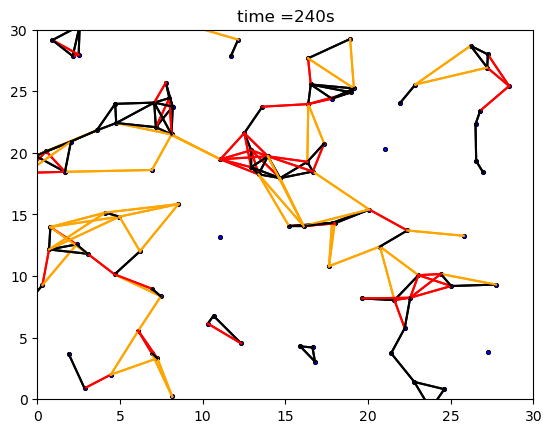

In [19]:
np.random.seed(1)

output_filename = 'output.mp4'
fps = 8
image_size = (640, 480)  # Adjust the size as per your image dimensions
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For MP4 format, use 'mp4v' or 'avc1'
video_writer = cv2.VideoWriter(output_filename, fourcc, fps, image_size)

total_time = 120
sim = NetworkSimulator(simulation_rate=2,update_rate=15*60)

real_plus_reported_edges = 0
real_reported_edges = 0

# Iterate over the range with tqdm
fig = plt.figure()
with tqdm(range(total_time), desc="Processing") as pbar:
    for i in pbar:
        sim.step()
        real_plus_reported_edges+= np.sum((sim.current_connectivity | sim.reported_connectivity))
        real_reported_edges+= np.sum(sim.current_connectivity & sim.reported_connectivity)
        accuracy = real_reported_edges/real_plus_reported_edges
        pbar.set_postfix({"accuracy":f"{accuracy:0.3}"})
        fig.clear()
        ax=plt.subplot(111)
        nt.visualize_nodes(sim.nodes,fig,'blue',is_plotly=False)
        nt.visualize_cmatrix(sim.nodes,sim.current_connectivity,fig,reported_cmatrix=sim.reported_connectivity,is_plotly=False)
        ax.set_title(f"time ={sim.current_time}s")
        ax.set_ylim(0,sim.distribution_params.area_size_y)
        ax.set_xlim(0,sim.distribution_params.area_size_x)
        canvas = fig.canvas
        canvas.draw()
        image_array = np.array(canvas.renderer.buffer_rgba())
        image_array = image_array[:,:,0:3] # to rgb
        image_array = image_array[:,:,[2,1,0]]
        video_writer.write(image_array)

video_writer.release()


In [ ]:
import scipy.ndimage as ndimage



def generate_terrain_height_map(size, max_elevation, smoothness):
    """
    Generates a randomized terrain height map for a rural area.

    Args:
        size (tuple): Size of the height map (rows, columns).
        max_elevation (float): Maximum elevation value for the terrain.
        smoothness (float): Controls the smoothness of the terrain. Higher values result in smoother terrain.

    Returns:
        numpy.ndarray: 2D array representing the terrain height map.
    """
    # Generate a random noise map
    noise_map = np.random.uniform(low=0.0, high=1.0, size=size)

    # Smooth the noise map using a Gaussian filter
    smoothed_map = ndimage.gaussian_filter(noise_map, sigma=smoothness)

    # Normalize the smoothed map to the desired elevation range
    normalized_map = max_elevation * (smoothed_map - np.min(smoothed_map)) / (np.max(smoothed_map) - np.min(smoothed_map))

    return normalized_map

ModuleNotFoundError: No module named 'scipy'

In [ ]:
x = generate_terrain_height_map((1000,1000),150,10)

In [ ]:
import matplotlib.pyplot as plt

def visualize_terrain_height_map(terrain_height_map):
    """
    Visualizes a terrain height map.

    Args:
        terrain_height_map (numpy.ndarray): 2D array representing the terrain height map.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(terrain_height_map, cmap='terrain', origin='lower')
    plt.colorbar(label='Elevation (m)')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Terrain Height Map')
    plt.show()

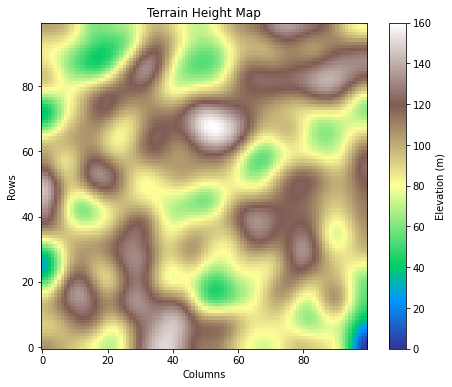

In [ ]:
terrain_map = generate_terrain_height_map(size=(100, 100), max_elevation=160, smoothness=5)
visualize_terrain_height_map(terrain_map)

Image array shape: (480, 640, 4)


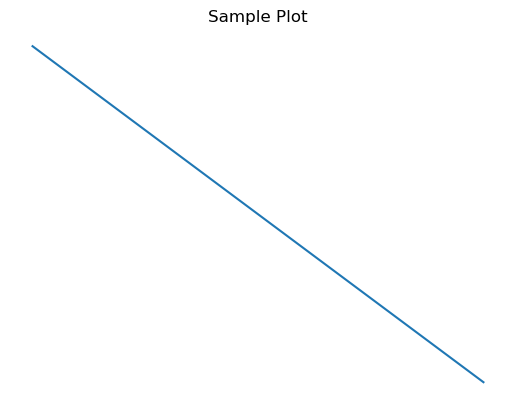

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a sample figure
fig, ax = plt.subplots()
ax.plot([1, 2, 3, 4, 5], [10, 8, 6, 4, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Sample Plot')
ax.axis('off')

# Export the figure to a NumPy image array
canvas = fig.canvas
canvas.draw()
image_array = np.array(canvas.renderer.buffer_rgba())

# Show the image array shape
print("Image array shape:", image_array.shape)

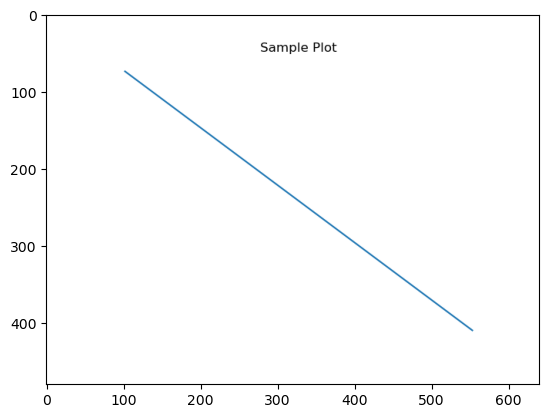

In [7]:
plt.imshow(image_array[:,:,0:3])
